# IRAN COVID-19 DATA ANALYSIS

In [13]:
from warnings import filterwarnings 
filterwarnings('ignore')

In [2]:
import os
import pandas as pd
import requests
import csv
from io import StringIO
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import scipy.stats as stats
import pylab
import scipy.stats as stats

In [3]:
!pip install requests

You should consider upgrading via the 'c:\programdata\anaconda3\python.exe -m pip install --upgrade pip' command.


In [4]:
d = requests.get("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv");
d.text
k = StringIO(d.text)
df1 = pd.read_csv(k)
df1.rename(columns={'Country/Region':'Country'}, inplace=True)
df1=df1.query('Country == "Iran"')
df1.rename(index={133:'Total_Patients_Died'}, inplace=True)

In [5]:
c = requests.get("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv");
c.text
c.text.replace("/","",100)
f = StringIO(c.text)
df2 = pd.read_csv(f) 
df2.rename(columns={'Country/Region':'Country'}, inplace=True)
df2=df2.query('Country == "Iran"')
df2.rename(index={133:'Total_Cases'}, inplace=True)

In [6]:
r = requests.get("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv");
r.text
r.text.replace("/","",100)
m = StringIO(r.text)
df3 = pd.read_csv(m)
df3.rename(columns={'Country/Region':'Country'}, inplace=True)
df3=df3.query('Country == "Iran"')
df3.rename(index={127:'Total_Patients_Treated'}, inplace=True)

In [7]:
df = pd.concat([df2, df1, df3])
df = df.dropna(how='all')
df.drop('Province/State', axis=1, inplace=True)
df.drop('Lat', axis=1, inplace=True)
df.drop('Long', axis=1, inplace=True)
df.drop('Country', axis=1, inplace=True)

In [8]:
dff=df.transpose()
tff=dff.loc[~(dff==0).all(axis=1)]
tff.index.name='Date'
tff.head()    #Total Cases

,Total_Cases,Total_Patients_Died,Total_Patients_Treated
Date,,,
2/19/20,2,2,0
2/20/20,5,2,0
2/21/20,18,4,0
2/22/20,28,5,0
2/23/20,43,8,0


In [9]:
import numpy as np
a1=np.zeros(((len(dff.index)),3))

In [10]:
for i in range(1,(len(dff.index))):
    a1[i,0]=dff.iloc[i,0]-dff.iloc[i-1,0]       
    a1[i,1]=dff.iloc[i,1]-dff.iloc[i-1,1]
    a1[i,2]=dff.iloc[i,2]-dff.iloc[i-1,2]

In [11]:
trr = pd.DataFrame(a1.astype(int), columns=("Daily_Cases","Daily_Patients_Died","Daily_Patients_Treated"), index=dff.index)
iran = trr.loc[~(trr==0).all(axis=1)]
iran.index.name='Date'

In [14]:
iran[iran < 0] = 0

In [15]:
iran.index = pd.to_datetime(iran.index)
tff.index = pd.to_datetime(tff.index)

## Data Analysis After First Death

When we look at the COVID-19 propagation process in general terms, we see that the distribution increases as exponential function.
However, not all cases can be detected, since countries cannot test enough when the virus first appeared.
For this reason, the distribution of data in the first days does not fit the general averages.
For example, we have seen that the mortality rate of the virus in Iran is 100%, then 20-40%.
On the other hand, that was around 2.5% in China.
Therefore, in this study, the analysis was made over the dates after the first case death, where the data began to approach the reality more than the first case.

In [16]:
tff["Death_Rate"] = tff["Total_Patients_Died"] / tff["Total_Cases"]

In [17]:
for i in range(0,len(tff.index)):
    if tff["Total_Patients_Died"][i] > 0:
        tff = tff.iloc[i:,::] 
        break
    else:
        continue

In [18]:
for i in range(0,len(iran.index)):
    if iran["Daily_Patients_Died"][i] > 0:
        iran = iran.iloc[i:,::] 
        break
    else:
        continue

### General Statistics of Data

In [28]:
iran.describe().T

,count,mean,std,min,25%,50%,75%,max
Daily_Cases,103.0,1470.543689,802.890853,2.0,1017.0,1383.0,2051.5,3186.0
Daily_Patients_Died,103.0,75.699029,44.838454,0.0,48.5,71.0,117.0,158.0
Daily_Patients_Treated,103.0,1153.864078,1000.442452,0.0,278.5,1111.0,1729.5,6482.0


## Data Visualization

### KDE Plots

The reason for taking the death rate value so wide is that it was very high in the first days.
However, a few days later this value became normal and began to concentrate around a value.

In [32]:
def limit(df , y):
    upper_limit = ((np.sort(df[y])[-1]) +  (np.sort(df[y])[-1])/4   )
    
    a = (np.sort(df[y])[0]) 

    if (a == 0):
        lower_limit = ((np.sort(df[y])[0]) - (np.sort(df[y])[-1])/8 )
    else:
        lower_limit = ((np.sort(df[y])[0]) -  (np.sort(df[y])[0])*15 )
        
    return (lower_limit,upper_limit)

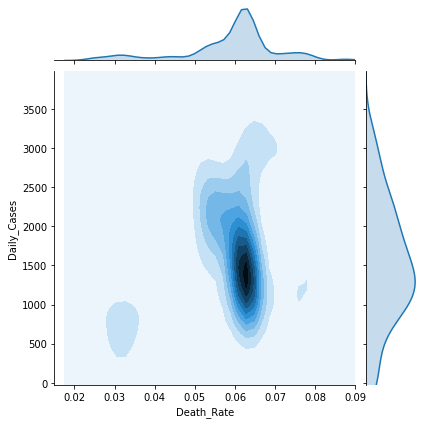

In [33]:
sns.jointplot(x=tff["Death_Rate"][3::], y=iran["Daily_Cases"][3::], data=iran,  kind="kde",
              xlim=(0.015,0.09),
             ylim=(limit(iran , "Daily_Cases")));

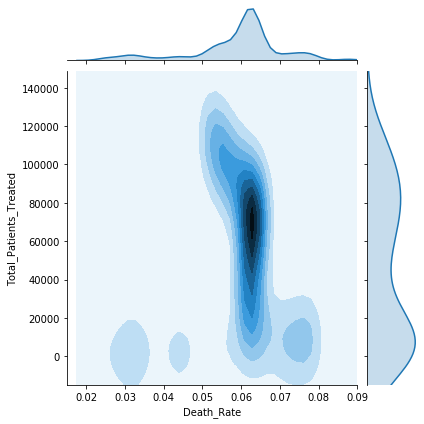

In [34]:
sns.jointplot(x=tff["Death_Rate"][3::], y=tff["Total_Patients_Treated"][3::] , data=tff, kind="kde" ,
             ylim=(limit(tff , "Total_Patients_Treated")),xlim=(0.015,0.09));

### Time Dependent Graphs

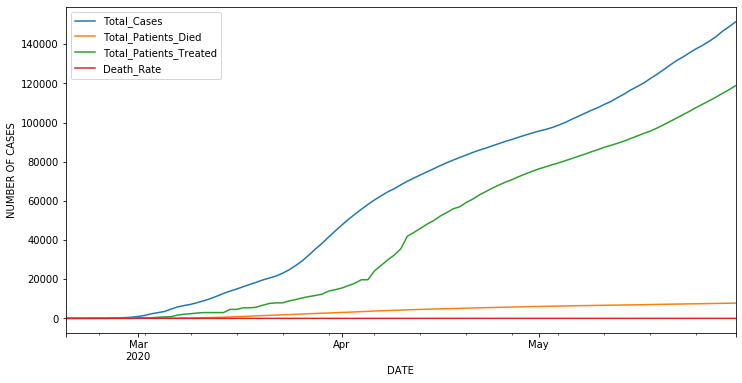

In [35]:
gra=tff.plot(figsize=(12,6))
gra.set_xlabel("DATE")
gra.set_ylabel("NUMBER OF CASES");

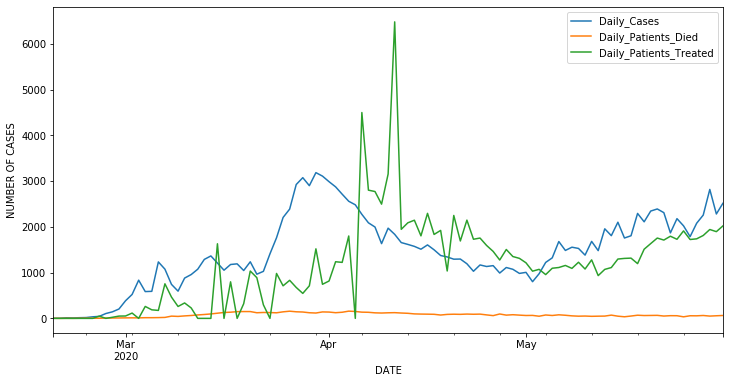

In [36]:
gra=iran.plot(figsize=(12,6))
gra.set_xlabel("DATE")
gra.set_ylabel("NUMBER OF CASES");

## Forecast

In [37]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from math import sqrt
from sklearn.metrics import mean_squared_error,r2_score
from pandas import read_csv
from matplotlib import pyplot
import numpy as np

In [38]:
# create a difference transform of the dataset
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return np.array(diff)

In [39]:
# Make a prediction give regression coefficients and lag obs
def predict(coef, history):
	yhat = coef[0]
	for i in range(1, len(coef)):
		yhat += coef[i] * history[-i]
	return yhat

In [42]:
series = iran['Daily_Cases']

Test RMSE: 294.064


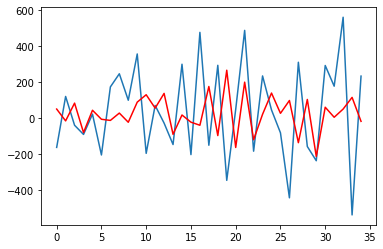

In [43]:
# split dataset
X = difference(series.values)
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:]
# train autoregression
window = 6
model = AutoReg(train, lags=6)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = [train[i] for i in range(len(train))]
predictions = list()
for t in range(len(test)):
	yhat = predict(coef, history)
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [44]:
# save model to file
model_fit.save('ar_model.pkl')
# save the differenced dataset
np.save('ar_data.npy', X)
# save the last ob
np.save('ar_obs.npy', [series.values[-1]])

In [45]:
# load the AR model from file
from statsmodels.tsa.ar_model import AutoRegResults
import numpy
loaded = AutoRegResults.load('ar_model.pkl')
print(loaded.params)
data = numpy.load('ar_data.npy')
last_ob = numpy.load('ar_obs.npy')
print(last_ob)

[12.65933995  0.15595489 -0.04099221  0.33059101  0.02171999  0.07314549
 -0.18382801]
[2516]


In [46]:
# load dataset
X = difference(series.values)
# fit model
window_size = 6
model = AutoReg(X, lags=window_size)
model_fit = model.fit()
# save coefficients
coef = model_fit.params
numpy.save('man_model.npy', coef)
# save lag
lag = X[-window_size:]
numpy.save('man_data.npy', lag)
# save the last ob
numpy.save('man_obs.npy', [series.values[-1]])

In [47]:
# load the manually saved model from file
import numpy
coef = numpy.load('man_model.npy')
print(coef)
lag = numpy.load('man_data.npy')
print(lag)
last_ob = numpy.load('man_obs.npy')
print(last_ob)

[24.56046155 -0.12335236  0.08705129  0.17108787  0.08992794  0.04909806
 -0.24676096]
[-236  293  178  561 -537  234]
[2516]


In [52]:
iran.tail()

,Daily_Cases,Daily_Patients_Died,Daily_Patients_Treated
Date,,,
2020-05-27,2080,56,1739
2020-05-28,2258,63,1812
2020-05-29,2819,50,1943
2020-05-30,2282,57,1896
2020-05-31,2516,63,2021


In [51]:
# load AR model from file and make a one-step prediction
from statsmodels.tsa.ar_model import AutoRegResults
import numpy
# load model
model = AutoRegResults.load('ar_model.pkl')
data = numpy.load('ar_data.npy')
last_ob = numpy.load('ar_obs.npy')
# make prediction
predictions = model.predict(start=len(data), end=len(data))
# transform prediction
yhat = predictions[0] + last_ob[0]
print('Forecast for tomorrow cases in Iran : %f' % yhat)

Forecast for tomorrow cases in Iran : 2566.990228
